In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np

from sklearn import svm
from sklearn import preprocessing, model_selection
from sklearn import metrics
from scipy import stats
from scipy.stats import norm
import pingouin as pg



from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


%matplotlib inline

# SVM Toy

In [2]:
def plot_regression_example(frequency, harmonics, C, kernel,gamma):

    harmonics = [int(x) for x in harmonics.split(',')]
    f = frequency
    odd = 1
    mult = 2
    t = np.linspace(0, 1, num=2000)
    y = np.zeros(2000)

    # compute and add fundamental with each harmonic
    for i in harmonics:
        k = i * mult + odd
        ys = (1/k)* np.sin(2 * np.pi * k *  f * t)
        yt = (1/(k*k) * (-1)**i)* np.sin(2 * np.pi * k *  f * t)
        y = y + ys + yt

    ynoise = y + np.random.randn(y.shape[0])*0.1
    # The classification SVC model
    X = t.reshape(-1,1)
    model = svm.SVR(kernel=kernel, C=C, gamma=gamma)
    clf = model.fit(X, ynoise)
    yhat = clf.predict(X)
    
  
    # Plot
    fig, ax = plt.subplots()
    ax.plot(t, ynoise, lw=2, label='Ruído')
    ax.plot(t, y, lw=2, label='Sinal')
    ax.plot(t, yhat, 'k-', lw=2, label='SVM')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Harmônicos {0}'.format(harmonics))
    plt.axis('tight')
    axis_lims = plt.axis()

    plt.show()
    

interact(plot_regression_example,
         frequency = [1, 2],
         harmonics = '1,2,3',
         C = [0.1, 1, 10, 1000],
         kernel = ['linear', 'rbf'],
         gamma = [1, 10, 100, 300, 'scale','auto']
        )

interactive(children=(Dropdown(description='frequency', options=(1, 2), value=1), Text(value='1,2,3', descript…

<function __main__.plot_regression_example(frequency, harmonics, C, kernel, gamma)>

# Automóveis


## Leitura da Base 

In [3]:
df_auto = pandas.read_csv('../Data/dataset_auto.csv',sep=';')
df_auto['model'] = df_auto['brand'].astype(str) + df_auto['model'].astype(str)

auto_target_col = 'price'

drop_cols = ['brand','tax']
df_auto.drop(drop_cols, axis=1, inplace=True)
print(df_auto.shape)
df_auto.head()

(15000, 8)


,model,year,price,transmission,mileage,fuelType,mpg,engineSize
0,audi A1,2020,20000,Manual,5000,Petrol,49.6,1.0
1,audi A5,2017,19995,Semi-Auto,54000,Diesel,67.3,2.0
2,audi A3,2017,11895,Manual,28334,Petrol,62.8,1.0
3,audi Q7,2018,56900,Semi-Auto,5330,Diesel,39.2,4.0
4,audi A4,2019,27160,Semi-Auto,17790,Diesel,47.9,2.0


# Transformação Variáveis Categóricas

In [4]:
categorical_cols = ['transmission', 'fuelType', 'model']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_auto[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_auto = pandas.concat([df_auto, ohe_df], axis=1).drop(cname, axis=1)

df_raw_auto = df_auto.copy()  
df_auto = df_raw_auto.sample(100).copy()
df_auto.head()

,year,price,mileage,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,...,model_ford Ka+,model_ford Kuga,model_ford Mondeo,model_ford Mustang,model_ford Puma,model_ford S-MAX,model_ford Streetka,model_ford Tourneo Connect,model_ford Tourneo Custom,model_ford Transit Tourneo
106,2019,39990,5000,38.2,3.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4070,2017,12525,52286,56.5,1.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14802,2014,6791,19612,44.1,1.6,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6812,2015,13399,40219,61.4,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7592,2016,12950,52647,65.7,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Treinamento Regressor

In [5]:
Y = df_auto[auto_target_col]
X = df_auto.drop(auto_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[auto_target_col] = ytrain
df_test[auto_target_col] = ytest


# C = [0.1, 1, 10, 1000],
# kernel = ['linear', 'rbf', 'poly']
# gamma = [1, 10, 100, 300, 'scale','auto']

model_auto = svm.SVR(kernel='linear', C=100)
model_auto = model_auto.fit(xtrain, ytrain)

df_train['prediction'] = model_auto.predict(xtrain)
df_test['prediction']  = model_auto.predict(xtest)

df_auto = pandas.concat((df_train, df_test), axis=0)


## Curva de Resíduos

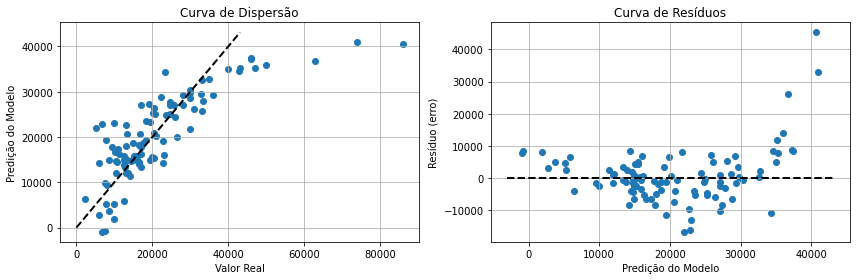

In [6]:
plt.figure(figsize=(12,4))

# Dispersion plot
plt.subplot(1,2,1)
plt.scatter(df_auto[auto_target_col], df_auto['prediction'])
plt.plot([0, plt.gca().axis()[3]],[0, plt.gca().axis()[3]],  '--k', lw=2)
plt.grid()
plt.ylabel('Predição do Modelo')
plt.xlabel('Valor Real')
plt.title(f'Curva de Dispersão')
plt.tight_layout()

plt.subplot(1,2,2)
error = df_auto[auto_target_col] - df_auto['prediction']
plt.scatter(df_auto['prediction'], error)
plt.plot([plt.gca().axis()[0], plt.gca().axis()[1]],[0, 0],  '--k', lw=2)
plt.grid()
plt.ylabel('Resíduo (erro)')
plt.xlabel('Predição do Modelo')
plt.title(f'Curva de Resíduos')
plt.tight_layout()

## Teste de Normalidade do Erro 

mu = 767.98 and sigma = 8434.07
Shapiro-Wilk p-value: 6.009173159071679e-09


C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


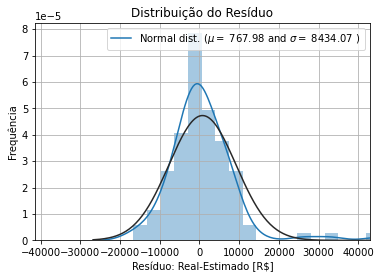

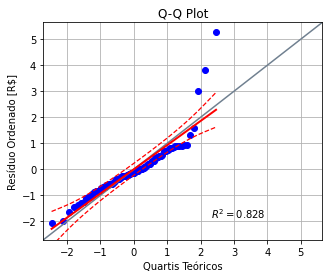

In [13]:

error = df_auto[auto_target_col] - df_auto['prediction']
(mu, sigma) = norm.fit(error.values.reshape((-1, 1)))
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
_, p_value = stats.shapiro(error)
print('Shapiro-Wilk p-value: ' + str(p_value))
# Get the fitted parameters used by the function
sns.distplot(error , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequência')
plt.xlabel('Resíduo: Real-Estimado [R$]')
plt.title(f'Distribuição do Resíduo')
plt.xlim((mu-5*sigma, mu+5*sigma))
plt.grid(True)
plt.show()
#Get also the QQ-plot
# res = stats.probplot(error, plot=plt)
pg.qqplot(error, dist='norm')
plt.xlabel('Quartis Teóricos')
plt.title(f'Q-Q Plot')
plt.ylabel('Resíduo Ordenado [R$]')
plt.grid(True)
plt.show()


# Clima


## Leitura dos Dados 

In [8]:
df_weather = pandas.read_csv('../Data/dataset_clima.csv',sep=';')

drop_cols = ['Temperature (C)']
df_weather.drop(drop_cols, axis=1, inplace=True)

print(df_weather.shape)

weather_target_col = 'Apparent Temperature (C)'

df_raw_weather = df_weather.copy()
df_weather = df_raw_weather.sample(100).copy()

df_weather.head()

(4019, 7)


,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
2017,28.619676,0.546250,9.114612,149.291667,11.183462,0.0,1014.808750
1706,15.315046,0.736667,16.729913,275.375000,12.077683,0.0,1015.612083
856,11.826852,0.838750,8.166054,131.125000,9.863933,0.0,1021.329167
594,26.618519,0.470417,9.521138,261.208333,12.111225,0.0,1012.872083
3733,6.808565,0.666667,12.033408,256.666667,10.574346,0.0,1014.642083


## Treinamento do Classificador 

In [9]:

Y = df_weather[weather_target_col]
X = df_weather.drop(weather_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[weather_target_col] = ytrain
df_test[weather_target_col] = ytest


# C = [0.1, 1, 10, 1000],
# kernel = ['linear', 'rbf', 'poly']
# gamma = [1, 10, 100, 300, 'scale','auto']

model_weather = svm.SVR(kernel='linear', C=100)
model_weather = model_weather.fit(xtrain, ytrain)


df_train['prediction'] = model_weather.predict(xtrain)
df_test['prediction']  = model_weather.predict(xtest)

df_weather = pandas.concat((df_train, df_test), axis=0)

## Curva de Resíduos

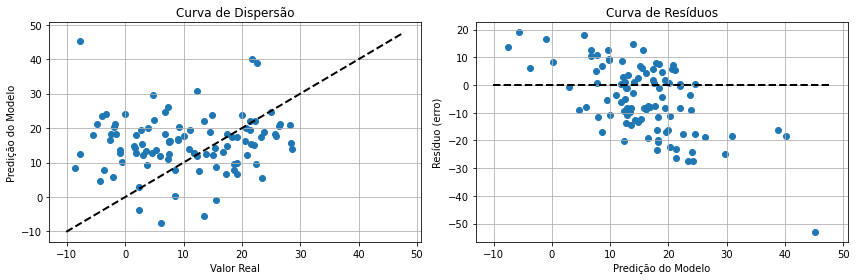

In [10]:
plt.figure(figsize=(12,4))

# Dispersion plot
plt.subplot(1,2,1)
plt.scatter(df_weather[weather_target_col], df_weather['prediction'])
plt.plot([plt.gca().axis()[2], plt.gca().axis()[3]],
         [plt.gca().axis()[2], plt.gca().axis()[3]],  '--k', lw=2)
plt.grid()
plt.ylabel('Predição do Modelo')
plt.xlabel('Valor Real')
plt.title(f'Curva de Dispersão')
plt.tight_layout()

plt.subplot(1,2,2)
error = df_weather[weather_target_col] - df_weather['prediction']
plt.scatter(df_weather['prediction'], error)
plt.plot([plt.gca().axis()[0], plt.gca().axis()[1]],[0, 0],  '--k', lw=2)
plt.grid()
plt.ylabel('Resíduo (erro)')
plt.xlabel('Predição do Modelo')
plt.title(f'Curva de Resíduos')
plt.tight_layout()

## Teste de Normalidade do Erro 

mu = -5.14 and sigma = 12.42
Shapiro-Wilk p-value: 0.028852704912424088


C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


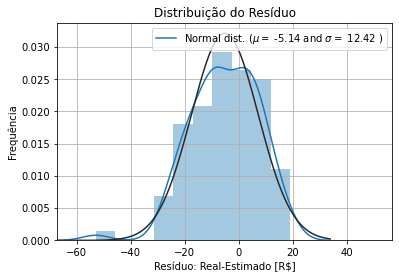

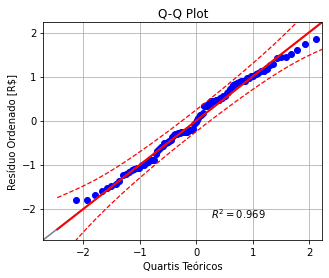

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\outdated\utils.py:18: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [12]:
error = df_weather[weather_target_col] - df_weather['prediction']
(mu, sigma) = norm.fit(error.values.reshape((-1, 1)))
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
_, p_value = stats.shapiro(error)
print('Shapiro-Wilk p-value: ' + str(p_value))
# Get the fitted parameters used by the function
sns.distplot(error , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequência')
plt.xlabel('Resíduo: Real-Estimado [R$]')
plt.title(f'Distribuição do Resíduo')
plt.xlim((mu-5*sigma, mu+5*sigma))
plt.grid(True)
plt.show()
#Get also the QQ-plot
pg.qqplot(error, dist='norm')
plt.xlabel('Quartis Teóricos')
plt.title(f'Q-Q Plot')
plt.ylabel('Resíduo Ordenado [R$]')
plt.grid(True)
plt.show()
